### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Current directory
print(os.getcwd())

# change directory
os.chdir('/content/drive/MyDrive/python_training/NLP100Days-part2/D15-word2vec-high_speed_lab/')
print(os.getcwd())

/content
/content/drive/MyDrive/python_training/NLP100Days-part2/D15-word2vec-high_speed_lab


### Import Necessary Libraries

In [3]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
# 讀取資料

# Penn Tree Back dataset
#./ptb.train
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [5]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [6]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
          #將所有字詞轉為小寫
          sentence = ' '.join(sentence).lower()
          #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
            
          if self.only_word:
              sentence = [word for word in re.findall(r"[a-zA-Z]*", sentence) if word != ""]
          else:
              punctuation_list = ['.', ',', '!', '?']
              for pun in punctuation_list:
                  sentence = sentence.replace(pun, ' '+pun)
              sentence = sentence.split(' ')
          #計算字詞頻率
          counter.update(sentence)
          processed_sentence.append(sentence)

        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        #添加字詞到字典中
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()


        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
    


        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            ###counter({'i': 169, 'to': 133, 'you': 131, 'the': 110, 'a': 105,...}) 
            word_cnt = dict(counter.items())
            ##word_cnt: {'point': 13, 'crazy': 15, 'available': 18, 'bugis': 7, 'great': 35, 'world': 23...}
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")

        
        # hint: 移除空字串
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        ##self.word_frequency, self.total_num_words 在後續negative sampling 使用
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words


    def subsampling(self, idx):        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        ##詞頻越大越不易被採樣到
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        
        return random.uniform(0, 1) < p_w


In [7]:
# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 888326 words
After subsampling: 434503 words


Before subsampling: 885720 words

After subsampling: 449198 words

### 定義Skip-gram使用的Dataset與collate function

In [8]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        ### <your code> ###
        return len(self.all_targets)
    
    def __getitem__(self, idx):
      # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            all_contexts += line[self.window_size:-self.window_size]
 
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                ### <your code> ###
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_targets.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))


        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
            ### <your code> ###
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                
                if neg_candidate[i] not in targets:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives) 
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        ### <your code> ###
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [9]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, embed_size) ## embed_size:vector length
        self.out_embedding = nn.Embedding(vocab_size, embed_size)

        
    def forward(self, contexts, targets):
        #v = torch.mean(self.in_embedding(contexts), dim=1) # [batch * (# per docs), embed_size]
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)

        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))

        return pred.squeeze(dim=1)

### 訓練

In [10]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)  # 學員可以自行選用optimizer
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 1, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)


In [11]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        ### <your code> ###
        
        if use_cuda:
            ### <your code> ###
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred, labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/686.23046875 Loss: 3.03951


  1%|          | 1/100 [00:02<03:48,  2.31s/it]

Epoch: 1/100, Loss: 2.76936
Epoch: 2/100, Batch: 501/686.23046875 Loss: 1.01356


  2%|▏         | 2/100 [00:04<03:43,  2.28s/it]

Epoch: 2/100, Loss: 0.97578
Epoch: 3/100, Batch: 501/686.23046875 Loss: 0.55514


  3%|▎         | 3/100 [00:06<03:42,  2.30s/it]

Epoch: 3/100, Loss: 0.56065
Epoch: 4/100, Batch: 501/686.23046875 Loss: 0.43691


  4%|▍         | 4/100 [00:09<03:37,  2.26s/it]

Epoch: 4/100, Loss: 0.44716
Epoch: 5/100, Batch: 501/686.23046875 Loss: 0.38715


  5%|▌         | 5/100 [00:11<03:33,  2.24s/it]

Epoch: 5/100, Loss: 0.39752
Epoch: 6/100, Batch: 501/686.23046875 Loss: 0.35547


  6%|▌         | 6/100 [00:13<03:34,  2.28s/it]

Epoch: 6/100, Loss: 0.36640
Epoch: 7/100, Batch: 501/686.23046875 Loss: 0.33156


  7%|▋         | 7/100 [00:15<03:29,  2.25s/it]

Epoch: 7/100, Loss: 0.34279
Epoch: 8/100, Batch: 501/686.23046875 Loss: 0.31183


  8%|▊         | 8/100 [00:17<03:25,  2.23s/it]

Epoch: 8/100, Loss: 0.32362
Epoch: 9/100, Batch: 501/686.23046875 Loss: 0.29583


  9%|▉         | 9/100 [00:20<03:26,  2.26s/it]

Epoch: 9/100, Loss: 0.30740
Epoch: 10/100, Batch: 501/686.23046875 Loss: 0.28285


 10%|█         | 10/100 [00:22<03:21,  2.24s/it]

Epoch: 10/100, Loss: 0.29350
Epoch: 11/100, Batch: 501/686.23046875 Loss: 0.27163


 11%|█         | 11/100 [00:24<03:17,  2.22s/it]

Epoch: 11/100, Loss: 0.28231
Epoch: 12/100, Batch: 501/686.23046875 Loss: 0.26149


 12%|█▏        | 12/100 [00:27<03:19,  2.27s/it]

Epoch: 12/100, Loss: 0.27225
Epoch: 13/100, Batch: 501/686.23046875 Loss: 0.25373


 13%|█▎        | 13/100 [00:29<03:14,  2.23s/it]

Epoch: 13/100, Loss: 0.26445
Epoch: 14/100, Batch: 501/686.23046875 Loss: 0.24820


 14%|█▍        | 14/100 [00:31<03:10,  2.21s/it]

Epoch: 14/100, Loss: 0.25771
Epoch: 15/100, Batch: 501/686.23046875 Loss: 0.24223


 15%|█▌        | 15/100 [00:33<03:09,  2.23s/it]

Epoch: 15/100, Loss: 0.25238
Epoch: 16/100, Batch: 501/686.23046875 Loss: 0.23768


 16%|█▌        | 16/100 [00:35<03:05,  2.21s/it]

Epoch: 16/100, Loss: 0.24763
Epoch: 17/100, Batch: 501/686.23046875 Loss: 0.23312


 17%|█▋        | 17/100 [00:37<03:02,  2.19s/it]

Epoch: 17/100, Loss: 0.24339
Epoch: 18/100, Batch: 501/686.23046875 Loss: 0.23086


 18%|█▊        | 18/100 [00:40<03:02,  2.22s/it]

Epoch: 18/100, Loss: 0.24001
Epoch: 19/100, Batch: 501/686.23046875 Loss: 0.22692


 19%|█▉        | 19/100 [00:42<03:00,  2.22s/it]

Epoch: 19/100, Loss: 0.23644
Epoch: 20/100, Batch: 501/686.23046875 Loss: 0.22426


 20%|██        | 20/100 [00:44<02:56,  2.21s/it]

Epoch: 20/100, Loss: 0.23413
Epoch: 21/100, Batch: 501/686.23046875 Loss: 0.22212


 21%|██        | 21/100 [00:46<02:57,  2.24s/it]

Epoch: 21/100, Loss: 0.23168
Epoch: 22/100, Batch: 501/686.23046875 Loss: 0.22044


 22%|██▏       | 22/100 [00:49<02:56,  2.26s/it]

Epoch: 22/100, Loss: 0.22972
Epoch: 23/100, Batch: 501/686.23046875 Loss: 0.21848


 23%|██▎       | 23/100 [00:51<02:55,  2.28s/it]

Epoch: 23/100, Loss: 0.22753
Epoch: 24/100, Batch: 501/686.23046875 Loss: 0.21665


 24%|██▍       | 24/100 [00:54<02:56,  2.32s/it]

Epoch: 24/100, Loss: 0.22621
Epoch: 25/100, Batch: 501/686.23046875 Loss: 0.21556


 25%|██▌       | 25/100 [00:56<02:53,  2.31s/it]

Epoch: 25/100, Loss: 0.22458
Epoch: 26/100, Batch: 501/686.23046875 Loss: 0.21368


 26%|██▌       | 26/100 [00:58<02:51,  2.32s/it]

Epoch: 26/100, Loss: 0.22306
Epoch: 27/100, Batch: 501/686.23046875 Loss: 0.21296


 27%|██▋       | 27/100 [01:01<02:51,  2.35s/it]

Epoch: 27/100, Loss: 0.22200
Epoch: 28/100, Batch: 501/686.23046875 Loss: 0.21125


 28%|██▊       | 28/100 [01:03<02:47,  2.33s/it]

Epoch: 28/100, Loss: 0.22076
Epoch: 29/100, Batch: 501/686.23046875 Loss: 0.20986


 29%|██▉       | 29/100 [01:05<02:42,  2.29s/it]

Epoch: 29/100, Loss: 0.21936
Epoch: 30/100, Batch: 501/686.23046875 Loss: 0.20983


 30%|███       | 30/100 [01:07<02:41,  2.30s/it]

Epoch: 30/100, Loss: 0.21853
Epoch: 31/100, Batch: 501/686.23046875 Loss: 0.20876


 31%|███       | 31/100 [01:10<02:40,  2.33s/it]

Epoch: 31/100, Loss: 0.21767
Epoch: 32/100, Batch: 501/686.23046875 Loss: 0.20866


 32%|███▏      | 32/100 [01:12<02:38,  2.32s/it]

Epoch: 32/100, Loss: 0.21736
Epoch: 33/100, Batch: 501/686.23046875 Loss: 0.20725


 33%|███▎      | 33/100 [01:14<02:34,  2.31s/it]

Epoch: 33/100, Loss: 0.21618
Epoch: 34/100, Batch: 501/686.23046875 Loss: 0.20724


 34%|███▍      | 34/100 [01:17<02:35,  2.35s/it]

Epoch: 34/100, Loss: 0.21557
Epoch: 35/100, Batch: 501/686.23046875 Loss: 0.20668


 35%|███▌      | 35/100 [01:19<02:31,  2.34s/it]

Epoch: 35/100, Loss: 0.21506
Epoch: 36/100, Batch: 501/686.23046875 Loss: 0.20528


 36%|███▌      | 36/100 [01:21<02:28,  2.32s/it]

Epoch: 36/100, Loss: 0.21428
Epoch: 37/100, Batch: 501/686.23046875 Loss: 0.20427


 37%|███▋      | 37/100 [01:24<02:28,  2.36s/it]

Epoch: 37/100, Loss: 0.21327
Epoch: 38/100, Batch: 501/686.23046875 Loss: 0.20471


 38%|███▊      | 38/100 [01:26<02:24,  2.33s/it]

Epoch: 38/100, Loss: 0.21342
Epoch: 39/100, Batch: 501/686.23046875 Loss: 0.20347


 39%|███▉      | 39/100 [01:28<02:20,  2.31s/it]

Epoch: 39/100, Loss: 0.21260
Epoch: 40/100, Batch: 501/686.23046875 Loss: 0.20444


 40%|████      | 40/100 [01:31<02:20,  2.34s/it]

Epoch: 40/100, Loss: 0.21280
Epoch: 41/100, Batch: 501/686.23046875 Loss: 0.20298


 41%|████      | 41/100 [01:33<02:17,  2.33s/it]

Epoch: 41/100, Loss: 0.21172
Epoch: 42/100, Batch: 501/686.23046875 Loss: 0.20257


 42%|████▏     | 42/100 [01:35<02:14,  2.31s/it]

Epoch: 42/100, Loss: 0.21168
Epoch: 43/100, Batch: 501/686.23046875 Loss: 0.20212


 43%|████▎     | 43/100 [01:38<02:11,  2.31s/it]

Epoch: 43/100, Loss: 0.21111
Epoch: 44/100, Batch: 501/686.23046875 Loss: 0.20196


 44%|████▍     | 44/100 [01:40<02:07,  2.27s/it]

Epoch: 44/100, Loss: 0.21075
Epoch: 45/100, Batch: 501/686.23046875 Loss: 0.20153


 45%|████▌     | 45/100 [01:42<02:03,  2.24s/it]

Epoch: 45/100, Loss: 0.21034
Epoch: 46/100, Batch: 501/686.23046875 Loss: 0.20120


 46%|████▌     | 46/100 [01:44<02:02,  2.27s/it]

Epoch: 46/100, Loss: 0.20977
Epoch: 47/100, Batch: 501/686.23046875 Loss: 0.20123


 47%|████▋     | 47/100 [01:47<01:59,  2.25s/it]

Epoch: 47/100, Loss: 0.20984
Epoch: 48/100, Batch: 501/686.23046875 Loss: 0.20018


 48%|████▊     | 48/100 [01:49<01:56,  2.24s/it]

Epoch: 48/100, Loss: 0.20922
Epoch: 49/100, Batch: 501/686.23046875 Loss: 0.20036


 49%|████▉     | 49/100 [01:51<01:55,  2.27s/it]

Epoch: 49/100, Loss: 0.20887
Epoch: 50/100, Batch: 501/686.23046875 Loss: 0.19992


 50%|█████     | 50/100 [01:53<01:52,  2.25s/it]

Epoch: 50/100, Loss: 0.20857
Epoch: 51/100, Batch: 501/686.23046875 Loss: 0.20007


 51%|█████     | 51/100 [01:56<01:49,  2.23s/it]

Epoch: 51/100, Loss: 0.20871
Epoch: 52/100, Batch: 501/686.23046875 Loss: 0.19932


 52%|█████▏    | 52/100 [01:58<01:49,  2.28s/it]

Epoch: 52/100, Loss: 0.20817
Epoch: 53/100, Batch: 501/686.23046875 Loss: 0.19886


 53%|█████▎    | 53/100 [02:00<01:46,  2.26s/it]

Epoch: 53/100, Loss: 0.20805
Epoch: 54/100, Batch: 501/686.23046875 Loss: 0.19949


 54%|█████▍    | 54/100 [02:02<01:43,  2.24s/it]

Epoch: 54/100, Loss: 0.20785
Epoch: 55/100, Batch: 501/686.23046875 Loss: 0.19848


 55%|█████▌    | 55/100 [02:05<01:40,  2.24s/it]

Epoch: 55/100, Loss: 0.20743
Epoch: 56/100, Batch: 501/686.23046875 Loss: 0.19935


 56%|█████▌    | 56/100 [02:07<01:39,  2.26s/it]

Epoch: 56/100, Loss: 0.20778
Epoch: 57/100, Batch: 501/686.23046875 Loss: 0.19862


 57%|█████▋    | 57/100 [02:09<01:35,  2.23s/it]

Epoch: 57/100, Loss: 0.20717
Epoch: 58/100, Batch: 501/686.23046875 Loss: 0.19832


 58%|█████▊    | 58/100 [02:11<01:33,  2.22s/it]

Epoch: 58/100, Loss: 0.20705
Epoch: 59/100, Batch: 501/686.23046875 Loss: 0.19846


 59%|█████▉    | 59/100 [02:14<01:32,  2.27s/it]

Epoch: 59/100, Loss: 0.20659
Epoch: 60/100, Batch: 501/686.23046875 Loss: 0.19790


 60%|██████    | 60/100 [02:16<01:30,  2.26s/it]

Epoch: 60/100, Loss: 0.20654
Epoch: 61/100, Batch: 501/686.23046875 Loss: 0.19783


 61%|██████    | 61/100 [02:18<01:27,  2.24s/it]

Epoch: 61/100, Loss: 0.20631
Epoch: 62/100, Batch: 501/686.23046875 Loss: 0.19810


 62%|██████▏   | 62/100 [02:20<01:26,  2.26s/it]

Epoch: 62/100, Loss: 0.20603
Epoch: 63/100, Batch: 501/686.23046875 Loss: 0.19668


 63%|██████▎   | 63/100 [02:23<01:23,  2.24s/it]

Epoch: 63/100, Loss: 0.20594
Epoch: 64/100, Batch: 501/686.23046875 Loss: 0.19766


 64%|██████▍   | 64/100 [02:25<01:19,  2.22s/it]

Epoch: 64/100, Loss: 0.20582
Epoch: 65/100, Batch: 501/686.23046875 Loss: 0.19728


 65%|██████▌   | 65/100 [02:27<01:19,  2.26s/it]

Epoch: 65/100, Loss: 0.20569
Epoch: 66/100, Batch: 501/686.23046875 Loss: 0.19748


 66%|██████▌   | 66/100 [02:29<01:16,  2.25s/it]

Epoch: 66/100, Loss: 0.20577
Epoch: 67/100, Batch: 501/686.23046875 Loss: 0.19758


 67%|██████▋   | 67/100 [02:32<01:13,  2.24s/it]

Epoch: 67/100, Loss: 0.20598
Epoch: 68/100, Batch: 501/686.23046875 Loss: 0.19663


 68%|██████▊   | 68/100 [02:34<01:12,  2.27s/it]

Epoch: 68/100, Loss: 0.20491
Epoch: 69/100, Batch: 501/686.23046875 Loss: 0.19691


 69%|██████▉   | 69/100 [02:36<01:09,  2.25s/it]

Epoch: 69/100, Loss: 0.20540
Epoch: 70/100, Batch: 501/686.23046875 Loss: 0.19634


 70%|███████   | 70/100 [02:38<01:06,  2.22s/it]

Epoch: 70/100, Loss: 0.20480
Epoch: 71/100, Batch: 501/686.23046875 Loss: 0.19621


 71%|███████   | 71/100 [02:41<01:05,  2.26s/it]

Epoch: 71/100, Loss: 0.20473
Epoch: 72/100, Batch: 501/686.23046875 Loss: 0.19608


 72%|███████▏  | 72/100 [02:43<01:02,  2.24s/it]

Epoch: 72/100, Loss: 0.20484
Epoch: 73/100, Batch: 501/686.23046875 Loss: 0.19561


 73%|███████▎  | 73/100 [02:45<01:00,  2.23s/it]

Epoch: 73/100, Loss: 0.20412
Epoch: 74/100, Batch: 501/686.23046875 Loss: 0.19609


 74%|███████▍  | 74/100 [02:47<00:58,  2.26s/it]

Epoch: 74/100, Loss: 0.20429
Epoch: 75/100, Batch: 501/686.23046875 Loss: 0.19600


 75%|███████▌  | 75/100 [02:50<00:56,  2.25s/it]

Epoch: 75/100, Loss: 0.20442
Epoch: 76/100, Batch: 501/686.23046875 Loss: 0.19606


 76%|███████▌  | 76/100 [02:52<00:53,  2.24s/it]

Epoch: 76/100, Loss: 0.20433
Epoch: 77/100, Batch: 501/686.23046875 Loss: 0.19575


 77%|███████▋  | 77/100 [02:54<00:52,  2.28s/it]

Epoch: 77/100, Loss: 0.20412
Epoch: 78/100, Batch: 501/686.23046875 Loss: 0.19575


 78%|███████▊  | 78/100 [02:56<00:49,  2.25s/it]

Epoch: 78/100, Loss: 0.20370
Epoch: 79/100, Batch: 501/686.23046875 Loss: 0.19508


 79%|███████▉  | 79/100 [02:58<00:46,  2.22s/it]

Epoch: 79/100, Loss: 0.20386
Epoch: 80/100, Batch: 501/686.23046875 Loss: 0.19534


 80%|████████  | 80/100 [03:01<00:44,  2.24s/it]

Epoch: 80/100, Loss: 0.20372
Epoch: 81/100, Batch: 501/686.23046875 Loss: 0.19474


 81%|████████  | 81/100 [03:03<00:42,  2.22s/it]

Epoch: 81/100, Loss: 0.20352
Epoch: 82/100, Batch: 501/686.23046875 Loss: 0.19500


 82%|████████▏ | 82/100 [03:05<00:39,  2.20s/it]

Epoch: 82/100, Loss: 0.20324
Epoch: 83/100, Batch: 501/686.23046875 Loss: 0.19501


 83%|████████▎ | 83/100 [03:07<00:37,  2.22s/it]

Epoch: 83/100, Loss: 0.20333
Epoch: 84/100, Batch: 501/686.23046875 Loss: 0.19524


 84%|████████▍ | 84/100 [03:10<00:36,  2.25s/it]

Epoch: 84/100, Loss: 0.20334
Epoch: 85/100, Batch: 501/686.23046875 Loss: 0.19470


 85%|████████▌ | 85/100 [03:12<00:33,  2.24s/it]

Epoch: 85/100, Loss: 0.20304
Epoch: 86/100, Batch: 501/686.23046875 Loss: 0.19493


 86%|████████▌ | 86/100 [03:14<00:31,  2.23s/it]

Epoch: 86/100, Loss: 0.20326
Epoch: 87/100, Batch: 501/686.23046875 Loss: 0.19415


 87%|████████▋ | 87/100 [03:17<00:29,  2.29s/it]

Epoch: 87/100, Loss: 0.20290
Epoch: 88/100, Batch: 501/686.23046875 Loss: 0.19419


 88%|████████▊ | 88/100 [03:19<00:27,  2.26s/it]

Epoch: 88/100, Loss: 0.20289
Epoch: 89/100, Batch: 501/686.23046875 Loss: 0.19387


 89%|████████▉ | 89/100 [03:21<00:24,  2.23s/it]

Epoch: 89/100, Loss: 0.20293
Epoch: 90/100, Batch: 501/686.23046875 Loss: 0.19360


 90%|█████████ | 90/100 [03:23<00:22,  2.25s/it]

Epoch: 90/100, Loss: 0.20247
Epoch: 91/100, Batch: 501/686.23046875 Loss: 0.19417


 91%|█████████ | 91/100 [03:25<00:19,  2.22s/it]

Epoch: 91/100, Loss: 0.20266
Epoch: 92/100, Batch: 501/686.23046875 Loss: 0.19429


 92%|█████████▏| 92/100 [03:27<00:17,  2.19s/it]

Epoch: 92/100, Loss: 0.20249
Epoch: 93/100, Batch: 501/686.23046875 Loss: 0.19366


 93%|█████████▎| 93/100 [03:30<00:15,  2.21s/it]

Epoch: 93/100, Loss: 0.20228
Epoch: 94/100, Batch: 501/686.23046875 Loss: 0.19433


 94%|█████████▍| 94/100 [03:32<00:13,  2.19s/it]

Epoch: 94/100, Loss: 0.20252
Epoch: 95/100, Batch: 501/686.23046875 Loss: 0.19306


 95%|█████████▌| 95/100 [03:34<00:10,  2.18s/it]

Epoch: 95/100, Loss: 0.20180
Epoch: 96/100, Batch: 501/686.23046875 Loss: 0.19332


 96%|█████████▌| 96/100 [03:36<00:08,  2.22s/it]

Epoch: 96/100, Loss: 0.20224
Epoch: 97/100, Batch: 501/686.23046875 Loss: 0.19358


 97%|█████████▋| 97/100 [03:39<00:06,  2.21s/it]

Epoch: 97/100, Loss: 0.20213
Epoch: 98/100, Batch: 501/686.23046875 Loss: 0.19264


 98%|█████████▊| 98/100 [03:41<00:04,  2.21s/it]

Epoch: 98/100, Loss: 0.20202
Epoch: 99/100, Batch: 501/686.23046875 Loss: 0.19318


 99%|█████████▉| 99/100 [03:43<00:02,  2.24s/it]

Epoch: 99/100, Loss: 0.20183
Epoch: 100/100, Batch: 501/686.23046875 Loss: 0.19364


100%|██████████| 100/100 [03:45<00:00,  2.26s/it]

Epoch: 100/100, Loss: 0.20183


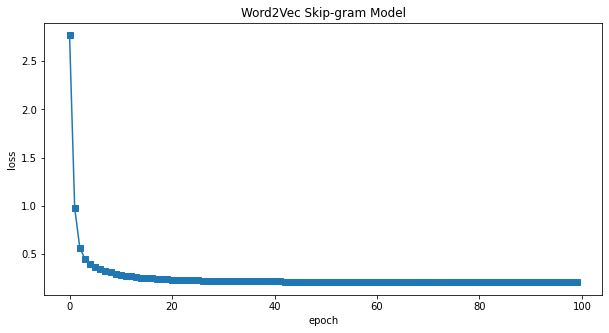

In [12]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [13]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.370: clout.
cosine sim=0.369: people.
cosine sim=0.356: producers.
cosine sim=0.342: wade.
